![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# Lecture 4 Support Notebook

### Table of Contents
<p>
<div class="lev1">
    <a href="#Simulated-Short-Corridor-Problem">
        <span class="toc-item-num">1&nbsp;&nbsp;</span>
        Simulated Short Corredor Problem
    </a>
</div>
<div class="lev1">
    <a href="#Short-Corredor-Problem-with-REINFORCE">
        <span class="toc-item-num">2&nbsp;&nbsp;</span>
        Short Corredor Problem with REINFORCE
    </a>
</div>
<div class="lev1">
    <a href="#Short-Corredor-Problem:-REINFORCE-with-Baseline">
        <span class="toc-item-num">3&nbsp;&nbsp;</span>
        Short Corredor Problem: REINFORCE with Baseline
    </a>
</div>
<div class="lev1">
    <a href="#Cliffwalking-Actor-Critic-for-Discrete-Action-Spaces"><span class="toc-item-num">4&nbsp;&nbsp;</span>
        Cliffwalking Actor Critic for Discrete Action Spaces
    </a>
</div>
<div class="lev1">
    <a href="#CartPole-with-Policy-Gradient"><span class="toc-item-num">5&nbsp;&nbsp;</span>
        CartPole with Policy Gradient
    </a>
</div>
<div class="lev1">
    <a href="#Tic-Tac-Toe-with-Policy-Gradient"><span class="toc-item-num">6&nbsp;&nbsp;</span>
        TiTac Toe with Policy Gradient
    </a>
</div>

# Simulated Short Corridor Problem

ref. https://github.com/jcassiojr/Reinforcement-Learning-In-Motion/tree/master/Unit-8-The-Mountaincar
others: reinforce, discrete and continuous mountain from sutton exercices (Policy Gradient)

In [1]:
!pip install gym

     |████████████████████████████████| 1.6 MB 19.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 54.7 MB/s eta 0:00:01
  Created wheel for gym: filename=gym-0.18.0-py3-none-any.whl size=1656449 sha256=0c68a71546218b28b3c081216d53c1e5fdea35a1aabfc668a1a12cc015a1393c
  Stored in directory: /home/ec2-user/.cache/pip/wheels/dd/c7/f0/a102782c25a396951685b12821797eaaad88e802e50271916f
Successfully built gym


In [2]:
%matplotlib inline

import gym
import itertools

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, Image
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
import sys
import tensorflow as tf
import collections

from scipy.stats import norm

if "../" not in sys.path:
    sys.path.append("../") 
from lib_rl.envs.cliff_walking import CliffWalkingEnv
from lib_rl import plotting

matplotlib.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')
# Continuous case libraries
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')


Consider the small corridor gridworld shown inset in the graph below. 
+ The reward is 1 per step. 
+ In each of the three nonterminal states there are only two actions, right and left. 
+ These actions have their usual consequences in the first and third states (left causes no movement in the first state)
+ In the secondstate they are reversed, so that right moves to the left and left moves to the right.

The problem is dicult because all the states appear identical under the function
approximation. In particular, we define x(s,right) = [1, 0]> and x(s, left) = [0, 1]>,
for all s. An action-value method with epsilon-greedy action selection is forced to choose
between just two policies: choosing right with high probability 1 - epsilon/2 on all steps
or choosing left with the same high probability on all time steps. If epsilon = 0.1, then
these two policies achieve a value (at the start state) of less than 44 and 82,
respectively, as shown in the graph. A method can do significantly better if it can
learn a specific probability with which to select right. The best probability is about
0.59, which achieves a value of about

<img src="../images/short-corridor-with-switched-actions.png" alt="Drawing" style="width: 300px;">

In [3]:
INIT_STATE = 0
TERMINAL_STATE = 3
# state that reverse the result of the action
REVERSE_STATE = 1
LEFT = -1
RIGHT = 1
ACTIONS = [LEFT, RIGHT]

def generate_an_episode(starting_state, greedy_action, prob_right):
    state = starting_state
    reward = 0
    while state != TERMINAL_STATE:
        if np.random.random() <= prob_right:
            
            act = RIGHT
        else:
            act = LEFT

        if state == REVERSE_STATE:
            state -= act
        else:
            state += act
        reward -= 1
        state = max(state, 0)
    return reward

### Policy 1  $\rightarrow \epsilon-greedy$ left
Policy chooses **left** with high right probability (95%), meaning going left has 5% probability.

In [4]:
epsilon = 0.1
# epsilon-greedy left
prob_right = epsilon / 2

rewards = []
for i in range(2000):
    rewards.append(generate_an_episode(INIT_STATE, RIGHT, prob_right))

In [5]:
np.mean(rewards)

-80.7355

<img src="../images/RL_lecture4_1.png" alt="Drawing" style="width: 300px;">

### Policy 2  $\rightarrow \epsilon-greedy$ right
Policy chooses **right** with high probability (95%)

In [6]:
epsilon = 0.1
# epsilon-greedy right
prob_right = (1 - epsilon) + epsilon / 2

rewards = []
for i in range(2000):
    rewards.append(generate_an_episode(INIT_STATE, RIGHT, prob_right))

In [7]:
np.mean(rewards)

-44.605

<img src="../images/RL_lecture4_1.png" alt="Drawing" style="width: 300px;">

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook"><span class="toc-item-num"></span>
        TOP
    </a>
</div>

# Short Corridor Problem with REINFORCE

<img src="../images/RL_lecture4_2.png" alt="Drawing" style="width: 600px;">

<img src="../images/short-corridor-with-switched-actions.png" alt="Drawing" style="width: 300px;">

In [8]:
!pip install tqdm

In [9]:
#######################################################################
# Copyright (C)                                                       #
# 2018 Sergii Bondariev (sergeybondarev@gmail.com)                    #
# 2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)                  #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm

In [10]:
def true_value(p):
    """ True value of the first state
    Args:
        p (float): probability of the action 'right'.
    Returns:
        True value of the first state.
        The expression is obtained by manually solving the easy linear system
        of Bellman equations using known dynamics.
    """
    return (2 * p - 4) / (p * (1 - p))

### Class that define the Short Corridor Environment
+ initialize initial state = 0
+ define the possible actions in function **step**

In [11]:
class ShortCorridor:
    """
    Short corridor environment, see Example 13.1
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 0

    def step(self, go_right):
        """
        Args:
            go_right (bool): chosen action
        Returns:
            tuple of (reward, episode terminated?)
        """
        if self.state == 0 or self.state == 2:
            if go_right:
                self.state += 1
            else:
                self.state = max(0, self.state - 1)
        else:
            if go_right:
                self.state -= 1
            else:
                self.state += 1

        if self.state == 3:
            # terminal state
            return 0, True
        else:
            return -1, False

### Implement policy parameterizations using the soft-max 

In [12]:
#def softmax(x):
#    t = np.exp(x - np.max(x))
#    return t / np.sum(t)

### Class that define the REINFORCE Agent
+ initialize step size $\alpha$ and discount factor $\gamma$
+ apply policy function **get_pi** using $\epsilon-greedy$
+ treat the episode end

In [13]:
class ReinforceAgent:
    """
    ReinforceAgent that follows algorithm
    'REINFORNCE Monte-Carlo Policy-Gradient Control (episodic)'
    """
    def __init__(self, alpha, gamma):
        # set values such that initial conditions correspond to left-epsilon greedy
        self.theta = np.array([-1.47, 1.47])
        self.alpha = alpha
        self.gamma = gamma
        # first column - left, second - right
        self.x = np.array([[0, 1],
                           [1, 0]])
        self.rewards = []
        self.actions = []

    def get_pi(self):
        h = np.dot(self.theta, self.x)
        t = np.exp(h - np.max(h))
        pmf = t / np.sum(t)
        # never become deterministic,
        # guarantees episode finish
        imin = np.argmin(pmf)
        epsilon = 0.05

        if pmf[imin] < epsilon:
            pmf[:] = 1 - epsilon
            pmf[imin] = epsilon

        return pmf

    def get_p_right(self):
        return self.get_pi()[1]

    def choose_action(self, reward):
        if reward is not None:
            self.rewards.append(reward)

        pmf = self.get_pi()
        go_right = np.random.uniform() <= pmf[1]
        self.actions.append(go_right)

        return go_right

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * G[i] * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

### Example Simulating with $\epsilon-greedy$
+ Plot the porbability distribution
+ Find and plot a maximum point
+ Plot points of two epsilon-greedy policies

In [14]:
def example_13_1():
    epsilon = 0.05
    fig, ax = plt.subplots(1, 1)

    # Plot a graph
    p = np.linspace(0.01, 0.99, 100)
    #print(p)
    y = true_value(p)
    #print(y)
    ax.plot(p, y, color='red')

    # Find a maximum point, can also be done analytically by taking a derivative
    imax = np.argmax(y)
    pmax = p[imax]
    ymax = y[imax]
    ax.plot(pmax, ymax, color='green', marker="*", label="optimal point: f({0:.2f}) = {1:.2f}".format(pmax, ymax))

    # Plot points of two epsilon-greedy policies
    ax.plot(epsilon, true_value(epsilon), color='magenta', marker="o", label="epsilon-greedy left")
    ax.plot(1 - epsilon, true_value(1 - epsilon), color='blue', marker="o", label="epsilon-greedy right")

    ax.set_ylabel("Value of the first state")
    ax.set_xlabel("Probability of the action 'right'")
    ax.set_title("Short corridor with switched actions")
    ax.set_ylim(ymin=-105.0, ymax=5)
    ax.legend()
    plt.show()
    #plt.savefig('./example_13_1.png')
    #plt.close()

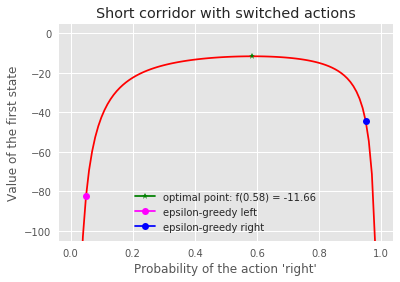

In [15]:
if __name__ == '__main__':
    example_13_1()

### Apply the REINFORCE Algorithm

In [16]:
def trial(num_episodes, agent_generator):
    env = ShortCorridor()
    agent = agent_generator()

    rewards = np.zeros(num_episodes)
    for episode_idx in range(num_episodes):
        rewards_sum = 0
        reward = None
        env.reset()

        while True:
            go_right = agent.choose_action(reward)
            reward, episode_end = env.step(go_right)
            rewards_sum += reward

            if episode_end:
                agent.episode_end(reward)
                break

        rewards[episode_idx] = rewards_sum

    return rewards

+ implement REINFORCE agent with three $\alpha$ values: 0.002, 0.0002 and 0.00002
+ discount factor $\gamma=1$
+ 100 trials with 1000 episodes each for each step size $alpha$
+ plot the results

In [17]:
def figure_13_1():
    num_trials = 100
    num_episodes = 1000
    gamma = 1
    agent_generators = [lambda : ReinforceAgent(alpha=2e-3, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-4, gamma=gamma),
                        lambda : ReinforceAgent(alpha=2e-5, gamma=gamma)
                        ]
    labels = ['alpha = 2e-3',
              'alpha = 2e-4',
              'alpha = 2e-5'
              ]

    rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

    for agent_index, agent_generator in enumerate(agent_generators):
        for i in tqdm(range(num_trials)):
            reward = trial(num_episodes, agent_generator)
            rewards[agent_index, i, :] = reward

    plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
    for i, label in enumerate(labels):
        plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')
    plt.show()
    #plt.savefig('./figure_13_1.png')
    #plt.close()

100%|██████████| 100/100 [04:46<00:00,  2.86s/it]


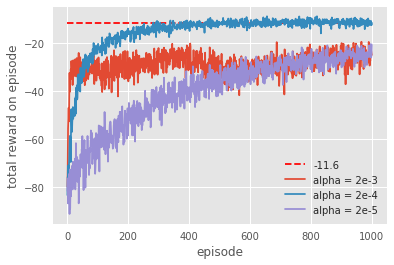

CPU times: user 10min 17s, sys: 332 ms, total: 10min 17s
Wall time: 10min 16s


In [18]:
%%time
if __name__ == '__main__':
    figure_13_1()

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook"><span class="toc-item-num"></span>
        TOP
    </a>
</div>

# Short Corridor Problem: REINFORCE with Baseline

<img src="../images/short-corridor-with-switched-actions.png" alt="Drawing" style="width: 300px;">

+ implement REINFORCE agent with baseline with $\alpha=0.0002$
+ discount factor $\gamma=1$
+ 100 trials with 1000 episodes each for each step size $alpha$
+ plot the results

In [19]:
class ReinforceBaselineAgent(ReinforceAgent):
    def __init__(self, alpha, gamma, alpha_w):
        super(ReinforceBaselineAgent, self).__init__(alpha, gamma)
        self.alpha_w = alpha_w
        self.w = 0

    def episode_end(self, last_reward):
        self.rewards.append(last_reward)

        # learn theta
        G = np.zeros(len(self.rewards))
        G[-1] = self.rewards[-1]

        for i in range(2, len(G) + 1):
            G[-i] = self.gamma * G[-i + 1] + self.rewards[-i]

        gamma_pow = 1

        for i in range(len(G)):
            self.w += self.alpha_w * gamma_pow * (G[i] - self.w)

            j = 1 if self.actions[i] else 0
            pmf = self.get_pi()
            grad_ln_pi = self.x[:, j] - np.dot(self.x, pmf)
            update = self.alpha * gamma_pow * (G[i] - self.w) * grad_ln_pi

            self.theta += update
            gamma_pow *= self.gamma

        self.rewards = []
        self.actions = []

In [20]:
def figure_13_2():
    num_trials = 100
    num_episodes = 1000
    alpha = 2e-4
    gamma = 1
    agent_generators = [lambda : ReinforceAgent(alpha=alpha, gamma=gamma),
                        lambda : ReinforceBaselineAgent(alpha=alpha*10, gamma=gamma, alpha_w=alpha*100)]
    labels = ['Reinforce without baseline',
              'Reinforce with baseline']

    rewards = np.zeros((len(agent_generators), num_trials, num_episodes))

    for agent_index, agent_generator in enumerate(agent_generators):
        for i in tqdm(range(num_trials)):
            reward = trial(num_episodes, agent_generator)
            rewards[agent_index, i, :] = reward

    plt.plot(np.arange(num_episodes) + 1, -11.6 * np.ones(num_episodes), ls='dashed', color='red', label='-11.6')
    for i, label in enumerate(labels):
        plt.plot(np.arange(num_episodes) + 1, rewards[i].mean(axis=0), label=label)
    plt.ylabel('total reward on episode')
    plt.xlabel('episode')
    plt.legend(loc='lower right')
    plt.show()
    #plt.savefig('./figure_13_2.png')
    #plt.close()

100%|██████████| 100/100 [01:32<00:00,  1.08it/s]


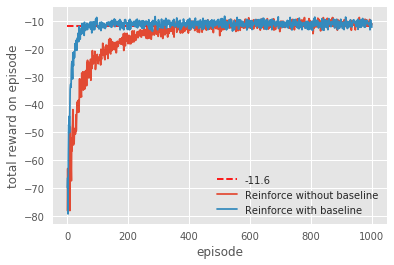

CPU times: user 3min 26s, sys: 147 ms, total: 3min 26s
Wall time: 3min 26s


In [21]:
%%time
if __name__ == '__main__':
    figure_13_2()

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook"><span class="toc-item-num"></span>
        TOP
    </a>
</div>

# Cliffwalking-Actor-Critic-for-Discrete-Action-Spaces
## Cliffwalking Environment

+ Gridworld environment for reinforcement learning from Sutton & Barto (2017). <br/>
+ Grid of shape 4x12 with a goal state in the bottom right of the grid. <br/>
+ Episodes start in the lower left state. Possible actions include going left, right, up and down. 
+ Some states in the lower part of the grid are a cliff, so taking a step into this cliff will yield a high negative reward of - 100 and move the agent back to the starting state. 
+ Elsewise rewards are - 1, 
+ for the goal state 0.
<img src="../images/cliff-walking.png" alt="Drawing" style="width: 600px;">

In [22]:
env = CliffWalkingEnv()

In [23]:
print("State space: ", env.observation_space)
print("Action space: ", env.action_space)

State space:  Discrete(48)
Action space:  Discrete(4)


In [24]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target
            # Adam: adaptativestep size to tweek learning rates
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [25]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [26]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    Actor Critic Algorithm. Optimizes the policy 
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            print("Transition: ",Transition)
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD Target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            estimator_value.update(state, td_target)
            
            # Update the policy estimator
            # using the td error as our advantage estimate
            estimator_policy.update(state, td_error, action)
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    
    return stats

In [27]:
import warnings
warnings.filterwarnings('ignore')
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator()
value_estimator = ValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    # Note, due to randomness in the policy the number of episodes you need to learn a good
    # policy may vary. ~300 seemed to work well for me.
    stats = actor_critic(env, policy_estimator, value_estimator, 300)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Transition:  <class '__main__.Transition'>
Step 0 @ Episode 1/300 (0.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 1/300 (0.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 1/300 (0.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 1/300 (0.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 2/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 2/30

Step 4 @ Episode 8/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 9/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 9/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 9/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 9/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 9/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 10/300 (-104.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 10/300 (-104.0

Step 35 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 36 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 37 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 38 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 39 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 40 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 41 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 42 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 43 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 44 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 45 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 46 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 47 @ Episode 13/300 (-130.0)Transition:  <class '__main__.Transition'>
Step 48 @ Ep

Step 88 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 89 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 90 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 91 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 92 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 93 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 94 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 95 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 96 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 97 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 98 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 99 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 100 @ Episode 15/300 (-103.0)Transition:  <class '__main__.Transition'>
Step 101 @ 

Step 17 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 20/300 (-133.0)Transition:  <class '__main__.Transition'>
Step 30 @ Ep

Step 20 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 30 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 31 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 32 @ Episode 23/300 (-176.0)Transition:  <class '__main__.Transition'>
Step 33 @ Ep

Step 63 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 64 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 65 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 66 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 67 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 68 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 69 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 70 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 71 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 72 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 73 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 74 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 75 @ Episode 24/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 76 @ Ep

Step 32 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 33 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 34 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 35 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 36 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 37 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 38 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 39 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 40 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 41 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 42 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 43 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 44 @ Episode 26/300 (-182.0)Transition:  <class '__main__.Transition'>
Step 45 @ Ep

Step 13 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 17 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 26 @ Ep

Step 141 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 142 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 143 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 144 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 145 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 146 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 147 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 148 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 149 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 150 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 151 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 152 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 153 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>

Step 264 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 265 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 266 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 267 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 268 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 269 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 270 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 271 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 272 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 273 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 274 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 275 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>
Step 276 @ Episode 28/300 (-186.0)Transition:  <class '__main__.Transition'>

Step 118 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 119 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 120 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 121 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 122 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 123 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 124 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 125 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 126 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 127 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 128 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 129 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 130 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>

Step 277 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 278 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 279 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 280 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 281 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 282 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 283 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 284 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 285 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 286 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 287 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 288 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 289 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>

Step 446 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 447 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 448 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 449 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 450 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 451 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 452 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 453 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 454 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 455 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 456 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 457 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>
Step 458 @ Episode 32/300 (-100.0)Transition:  <class '__main__.Transition'>

Step 49 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 50 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 51 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 52 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 53 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 54 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 55 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 56 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 57 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 58 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 59 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 60 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 61 @ Episode 35/300 (-155.0)Transition:  <class '__main__.Transition'>
Step 62 @ Ep

Step 17 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 37/300 (-159.0)Transition:  <class '__main__.Transition'>
Step 30 @ Ep

Step 125 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 126 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 127 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 128 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 129 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 130 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 131 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 132 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 133 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 134 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 135 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 136 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>
Step 137 @ Episode 38/300 (-148.0)Transition:  <class '__main__.Transition'>

Step 98 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 99 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 100 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 101 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 102 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 103 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 104 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 105 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 106 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 107 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 108 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 109 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 110 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
S

Step 262 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 263 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 264 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 265 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 266 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 267 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 268 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 269 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 270 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 271 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 272 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 273 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 274 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>

Step 427 @ Episode 39/300 (-294.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 40/

Step 167 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 168 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 169 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 170 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 171 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 172 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 173 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 174 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 175 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 176 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 177 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 178 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>
Step 179 @ Episode 40/300 (-527.0)Transition:  <class '__main__.Transition'>

Step 10 @ Episode 41/300 (-323.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 42/300 (-110.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 43/300 (-105.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 43/300 

Step 21 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 30 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 31 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 32 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 33 @ Episode 45/300 (-216.0)Transition:  <class '__main__.Transition'>
Step 34 @ Ep

Step 151 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 152 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 153 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 154 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 155 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 156 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 157 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 158 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 159 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 160 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 161 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 162 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 163 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>

Step 316 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 317 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 318 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 319 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 320 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 321 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 322 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 323 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 324 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 325 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 326 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 327 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 328 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>

Step 482 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 483 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 484 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 485 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 486 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 487 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 488 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 489 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 490 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 491 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 492 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 493 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 494 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>

Step 645 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 646 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 647 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 648 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 649 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 650 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 651 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 652 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 653 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 654 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 655 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 656 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 657 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>

Step 814 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 815 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 816 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 817 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 818 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 819 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 820 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 821 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 822 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 823 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 824 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 825 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>
Step 826 @ Episode 46/300 (-138.0)Transition:  <class '__main__.Transition'>

Step 15 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 17 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 47/300 (-963.0)Transition:  <class '__main__.Transition'>
Step 28 @ Ep

Step 7 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 17 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 49/300 (-106.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episo

Step 82 @ Episode 52/300 (-124.0)Transition:  <class '__main__.Transition'>
Step 83 @ Episode 52/300 (-124.0)Transition:  <class '__main__.Transition'>
Step 84 @ Episode 52/300 (-124.0)Transition:  <class '__main__.Transition'>
Step 85 @ Episode 52/300 (-124.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 53/300 (-86.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 53/300 (-86.0

Step 37 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 38 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 39 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 40 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 41 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 42 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 43 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 44 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 45 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 46 @ Episode 54/300 (-224.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 55/300 (-146.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 55/300 (-146.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 56/300 (-101.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episod

Step 63 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 64 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 65 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 66 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 67 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 68 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 69 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 70 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 71 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 72 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 73 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 74 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 75 @ Episode 57/300 (-84.0)Transition:  <class '__main__.Transition'>
Step 76 @ Episode 57/300 

Step 24 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 30 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 31 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 32 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 33 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 34 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 35 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 36 @ Episode 61/300 (-56.0)Transition:  <class '__main__.Transition'>
Step 37 @ Episode 61/300 

Step 17 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 20 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 21 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 22 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 23 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 24 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 25 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 26 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 27 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 28 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 29 @ Episode 64/300 (-54.0)Transition:  <class '__main__.Transition'>
Step 30 @ Episode 64/300 

Step 1 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 70/300 (-31.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 70/300 (-31.0)Tr

Step 17 @ Episode 77/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 78/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 78/300 (-18.0)Tra

Step 4 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 86/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 87/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 87/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 87/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 87/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 87/300 (-13.0)Tran

Step 2 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 95/300 (-24.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 95/300 (-24.0)T

Step 5 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 104/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 105/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 105/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 105/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 105/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 105/300 (-13.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 105/3

Step 10 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 114/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 115/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 1

Step 3 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 125/300 (-21.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 12

Step 2 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 136/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 137

Step 9 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 146/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 147/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 147

Step 4 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 156/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 17 @ Episode 

Step 7 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 165/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 166/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 166/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 166/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 166/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 16

Step 9 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 174/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 175/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 175/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 175/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 175/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 175/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 1

Step 5 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 185/300 (-18.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 186/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 186/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 186/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 186

Step 2 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 196/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 19

Step 14 @ Episode 205/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 205/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 16 @ Episode 205/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 17 @ Episode 205/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 18 @ Episode 205/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 206/300 (-19.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 206

Step 12 @ Episode 215/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 215/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 215/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 216/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 216/

Step 0 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 226/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 226/

Step 18 @ Episode 235/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 19 @ Episode 235/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 236/300 (-20.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 236/

Step 13 @ Episode 245/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 245/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 15 @ Episode 245/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 246/300 (-16.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 246/

Step 14 @ Episode 253/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 254/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 254/

Step 6 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 264/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 265/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 265/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 265/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 265/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 265

Step 6 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 274/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 275/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 275/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 275/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 275/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 275

Step 4 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 14 @ Episode 284/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 0 @ Episode 285/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 285/300 (-15.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 285

Step 0 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 1 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 2 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 3 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 4 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 5 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 6 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 7 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 8 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 9 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 10 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 11 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 12 @ Episode 295/300 (-17.0)Transition:  <class '__main__.Transition'>
Step 13 @ Episode 295/

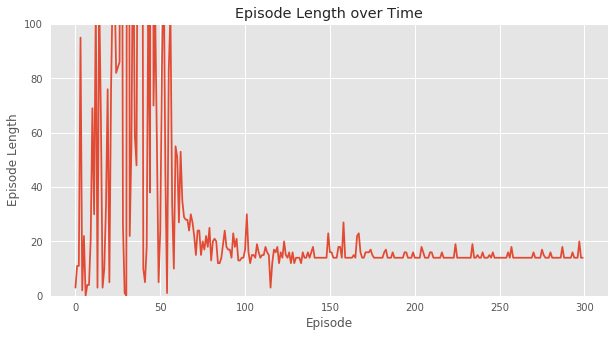

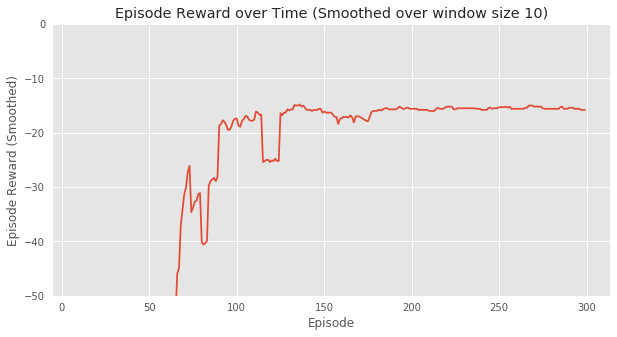

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [28]:
plotting.plot_episode_stats(stats, (0,100), (-50,0), smoothing_window=10)

##### Episode lenght over time shows that it converge to around 12 steps
##### Episode reward over time shows that it converge to around -12 (makes sense related to the time steps)

## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook"><span class="toc-item-num"></span>
        TOP
    </a>
</div>

# CartPole with Policy Gradient
This is a simple example of how to build a policy-gradient based agent that can solve the CartPole problem. For more information, see the post below. This implementation is generalizable to more than two actions.

ref. https://medium.com/@awjuliani/super-simple-reinforcement-learning-tutorial-part-2-ded33892c724#.mtwpvfi8b

## Environment
<img src="../images/cartpole_01.png" alt="Drawing" style="width: 300px;">
<img src="../images/cartpole_02.png" alt="Drawing" style="width: 300px;">

### Reward
Reward is 1 for every step taken, including the termination step.
### Starting State
All observations are assigned a uniform random value between ±0.05.

### Episode Termination
+ Pole Angle is more than ±12°
+ Cart Position is more than ±2.4 (center of the cart reaches the edge of the display)
+ Episode length is greater than 200.

### Solved Requirements
Considered solved when the average reward is greater than or equal to 195.0 over 100 consecutive trials.

In [29]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import numpy as np
import gym
import matplotlib.pyplot as plt
%matplotlib inline

try:
    xrange = xrange
except:
    xrange = range

In [30]:
env = gym.make('CartPole-v1')

In [31]:
env.observation_space.sample()

array([ 2.9788084e+00, -3.5676857e+36,  3.7325776e-01, -1.3138874e+38],
      dtype=float32)

In [32]:
#env.action_space.sample()

In [33]:
#np.set_printoptions(precision=2)
#print("max cart position and velocity: ",env.observation_space.high)
#print("min cart position and velocity: ", env.observation_space.low)


In [34]:
print("State space: ", env.observation_space)
print("Action space: ", env.action_space) # 0 or 1

State space:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Action space:  Discrete(2)


## The Policy-Based Agent
Computes the discounted rewards

In [35]:
def discount_rewards(r):
    """ take 1D float array of rewards and compute discounted reward """
    discounted_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(xrange(0, r.size)):
        running_add = running_add * gamma + r[t]
        discounted_r[t] = running_add
    return discounted_r

In [36]:
class agent():
    def __init__(self, lr, s_size,a_size,h_size):
        #################################################################
        # These lines established the feed-forward part of the network. 
        #################################################################
        # The agent takes a state and produces an action.
        self.state_in= tf.placeholder(shape=[None,s_size],dtype=tf.float32)
        # define a fully connected hidden layer using ReLu as activation function
        hidden = slim.fully_connected(self.state_in,h_size,biases_initializer=None,
                                      activation_fn=tf.nn.relu)
        # define an output layer using softmax as activation function
        self.output = slim.fully_connected(hidden,a_size,activation_fn=tf.nn.softmax,
                                           biases_initializer=None)
        self.chosen_action = tf.argmax(self.output,1)

        #########################################################
        # The next lines establish the training proceedure. 
        #########################################################
        # We feed the reward and chosen action into the network
        # to compute the loss, and use it to update the network.
        self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
        self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
        
        self.indexes = tf.range(0, tf.shape(self.output)[0]) * tf.shape(self.output)[1] + \
                                                                    self.action_holder
        self.responsible_outputs = tf.gather(tf.reshape(self.output, [-1]), self.indexes)

        self.loss = -tf.reduce_mean(tf.log(self.responsible_outputs)*self.reward_holder)
        
        tvars = tf.trainable_variables()
        self.gradient_holders = []
        for idx,var in enumerate(tvars):
            placeholder = tf.placeholder(tf.float32,name=str(idx)+'_holder')
            self.gradient_holders.append(placeholder)
        
        self.gradients = tf.gradients(self.loss,tvars)
        optimizer = tf.train.AdamOptimizer(learning_rate=lr)
        self.update_batch = optimizer.apply_gradients(zip(self.gradient_holders,tvars))

### Training the Agent


In [37]:
gamma = 0.99 # discount factor

tf.reset_default_graph() # Clear the Tensorflow graph.
# initialize agent with learning rate
myAgent = agent(lr=1e-2,s_size=4,a_size=2,h_size=8) #Load the agent.

total_episodes = 2000 # Set total number of episodes to train agent on.
max_ep = 999
update_frequency = 5

init = tf.global_variables_initializer()

# Launch the tensorflow graph
with tf.Session() as sess:
    sess.run(init)
    i = 0
    total_reward = []
    total_length = []
        
    gradBuffer = sess.run(tf.trainable_variables())
    for ix,grad in enumerate(gradBuffer):
        gradBuffer[ix] = grad * 0
    # run episodes
    while i < total_episodes:
        s = env.reset()
        running_reward = 0
        ep_history = []
        for j in range(max_ep):
            # Probabilistically pick an action given our network outputs.
            a_dist = sess.run(myAgent.output,feed_dict={myAgent.state_in:[s]})
            a = np.random.choice(a_dist[0],p=a_dist[0])
            a = np.argmax(a_dist == a)
            s1,r,d,_ = env.step(a) #Get our reward for taking an action given a bandit.
            #print("a: {}, S1: {}, r: {}, done: {}".format(a, s1,r,d))
            ep_history.append([s,a,r,s1])
            s = s1
            running_reward += r
            if d == True:
                
                #Update the network.
                ep_history = np.array(ep_history)
                ep_history[:,2] = discount_rewards(ep_history[:,2])
                feed_dict={myAgent.reward_holder:ep_history[:,2],
                        myAgent.action_holder:ep_history[:,1],myAgent.state_in:np.vstack(ep_history[:,0])}
                grads = sess.run(myAgent.gradients, feed_dict=feed_dict)
                for idx,grad in enumerate(grads):
                    gradBuffer[idx] += grad

                if i % update_frequency == 0 and i != 0:
                    feed_dict= dictionary = dict(zip(myAgent.gradient_holders, gradBuffer))
                    _ = sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    for ix,grad in enumerate(gradBuffer):
                        gradBuffer[ix] = grad * 0
                
                total_reward.append(running_reward)
                total_length.append(j)
                break

        
            #Update our running tally of scores.
        if i % 100 == 0:
            print("Average reward for each 100 trials: {}".format(np.mean(total_reward[-100:])))
        i += 1

Average reward for each 100 trials: 21.0
Average reward for each 100 trials: 41.12
Average reward for each 100 trials: 55.63
Average reward for each 100 trials: 76.17
Average reward for each 100 trials: 96.18
Average reward for each 100 trials: 131.5
Average reward for each 100 trials: 188.2
Average reward for each 100 trials: 215.62
Average reward for each 100 trials: 218.92
Average reward for each 100 trials: 348.96
Average reward for each 100 trials: 369.54
Average reward for each 100 trials: 366.53
Average reward for each 100 trials: 380.68
Average reward for each 100 trials: 326.87
Average reward for each 100 trials: 338.0
Average reward for each 100 trials: 423.07
Average reward for each 100 trials: 448.82
Average reward for each 100 trials: 484.01
Average reward for each 100 trials: 460.02
Average reward for each 100 trials: 257.42


## End of Example.  Return to Slides

![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

<div class="lev1">
    <a href="#Lecture-4-Support-Notebook"><span class="toc-item-num"></span>
        TOP
    </a>
</div>

# Tic Tac Toe with Policy Gradient  Descent
This is a simple example of how to build a policy-gradient based agent that can solve the Tic Tac Toe problem. 
> We are going to play against a random player first, for two different approaches: 
+ Being the first to start (you have a slight advantage being the first in Tic Tac Toe)
+ Being the second to start

> Then, we are going to play with a Minimax player (Using a decision rule for minimizing the possible loss for a worst case (maximum loss) scenario. 
Again, we are going to experiment as a first playes to start and then the second.

# Time to take it for a spin

We start with the easiest case, going first against the Random Player:

In [38]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt

from util import evaluate_players
from tic_tac_toe.TFSessionManager import TFSessionManager
from tic_tac_toe.RandomPlayer import RandomPlayer
from tic_tac_toe.RndMinMaxAgent import RndMinMaxAgent
from tic_tac_toe.DirectPolicyAgent import DirectPolicyAgent

Instructions for updating:
Use keras.layers.Dense instead.







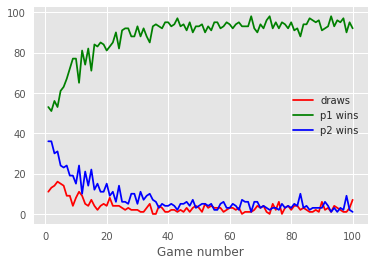

CPU times: user 58.8 s, sys: 3.08 s, total: 1min 1s
Wall time: 40.4 s


In [39]:
%%time
tf.reset_default_graph()

nnplayer = DirectPolicyAgent("PolicyLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rndplayer, 
                                                        num_battles=100, silent=True)


fig, ax = plt.subplots()
ax.plot(game_number, draws, '-r', label='draws')
ax.plot(game_number, p1_wins, '-g', label='p1 wins')
ax.plot(game_number, p2_wins, '-b', label='p2 wins')
ax.legend()
ax.set_xlabel("Game number")
plt.show()

TFSessionManager.set_session(None)

Not bad at all. 
We would get typically less than 5% losses. 
Let's try going second agains the Random Player:

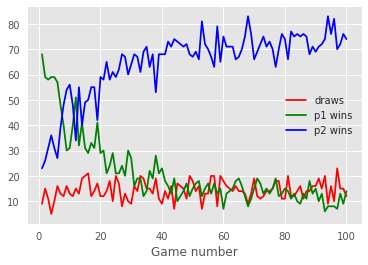

CPU times: user 59.1 s, sys: 2.94 s, total: 1min 2s
Wall time: 40.8 s


In [40]:
%%time
tf.reset_default_graph()

nnplayer = DirectPolicyAgent("PolicyLearner1")
rndplayer = RandomPlayer()

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rndplayer, nnplayer, 
                                                        num_battles=100, silent=True)

fig, ax = plt.subplots()
ax.plot(game_number, draws, '-r', label='draws')
ax.plot(game_number, p1_wins, '-g', label='p1 wins')
ax.plot(game_number, p2_wins, '-b', label='p2 wins')
ax.legend()
ax.set_xlabel("Game number")
plt.show()

TFSessionManager.set_session(None)

Not perfect with about 5% to 10% losses, but again a solid performance.

Let's try going first against the non-deterministic Min-Max:

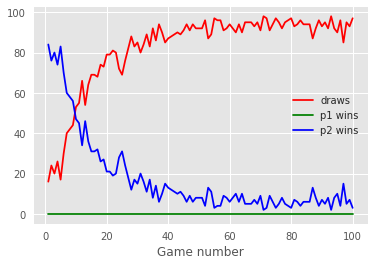

CPU times: user 1min 5s, sys: 3.39 s, total: 1min 9s
Wall time: 46.4 s


In [41]:
%%time
tf.reset_default_graph()

nnplayer = DirectPolicyAgent("PolicyLearner1") # Player 1
rm_player = RndMinMaxAgent() # Player 2

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(nnplayer, rm_player, 
                                                        num_battles=100, silent=True)

fig, ax = plt.subplots()
ax.plot(game_number, draws, '-r', label='draws')
ax.plot(game_number, p1_wins, '-g', label='p1 wins')
ax.plot(game_number, p2_wins, '-b', label='p2 wins')
ax.legend()
ax.set_xlabel("Game number")
plt.show()
TFSessionManager.set_session(None)

Pretty solid again with draws in the 90%. 

Finally going second against the non-deterministic Min Max:

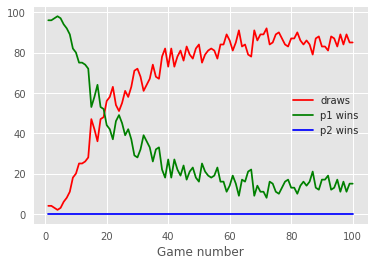

CPU times: user 58 s, sys: 3.28 s, total: 1min 1s
Wall time: 40.3 s


In [42]:
%%time
tf.reset_default_graph()

nnplayer = DirectPolicyAgent("PolicyLearner1") # Player 2
rm_player = RndMinMaxAgent() # Player 1

TFSessionManager.set_session(tf.Session())
TFSessionManager.get_session().run(tf.global_variables_initializer())

game_number, p1_wins, p2_wins, draws = evaluate_players(rm_player, nnplayer, 
                                                        num_battles=100, silent=True)

fig, ax = plt.subplots()
ax.plot(game_number, draws, '-r', label='draws')
ax.plot(game_number, p1_wins, '-g', label='p1 wins')
ax.plot(game_number, p2_wins, '-b', label='p2 wins')
ax.legend()
ax.set_xlabel("Game number")
plt.show()

TFSessionManager.set_session(None)

Again, surprisingly solid with almost all runs ending in above 90% draws.

## Conclusion
We have introduced Policy Gradient Descent as an alternative method to Q learning as a Reinforcement Learning method. We have also seen how to implement it in Tensorflow in our Tic Tac Toe example.